# Heat-equation in 1D and 2D with DDA

The [heat equation](https://en.wikipedia.org/wiki/Heat_equation) is a partial differential equation (PDE). Being an elliptical equation with a Laplace operator, so second order in space, first order in time, it is one of the typical text-book introductions. It describes the fate of a given field $u=u(\vec x, t)$, and is given by

$$ \frac{\partial u}{\partial t} = \alpha \nabla^2 u$$

where $\nabla^2$ is the Laplace operator $\nabla^2 = \sum_{i=1}^d \partial^2 / \partial^2 x_i$ in $d$ spatial dimensions and $\alpha$ is a constant for driving the coupling/gain.

The aim of this notebook is to demonstrate how to solve the heat-equation in one and two spatial dimensions with DDA or an analog computer, respectively. To do so, we use the [method of lines](https://en.wikipedia.org/wiki/Method_of_lines) to convert the PDE in a set of ordinary differential equations (ODEs), which itself are spatially discretized with [central finite differences](https://en.wikipedia.org/wiki/Finite_difference).

This example follows the [Analog Paradigm Application Notes 24](http://analogparadigm.com/downloads/alpaca_24.pdf), where a circuit and further comments on symmetries can be found.

For initial data, we will always model a singular peak $u_0(\vec x) = \delta(\vec x_0)$ at some position $\vec x_0$. Discretized, this translates to having all $u_i=0$ for all $i$ except one where $u_i=1$.

In [1]:
from numpy import *
from dda import *
from dda.computing_elements import *
from dda.cpp_exporter import compile, run
from matplotlib.pyplot import *

In [2]:
alpha = const(4)

## 1D Heat equation
For the beginning, we solve the heat equation in one temporal and one spatial dimension.

First, we define the symbols $u$ and $u0$ and the initial data:

In [3]:
state = State() # start with a fresh state

N = 10 # supporting points
u = [ Symbol(f"u{i}") for i in range(N)  ]

# Initial conditions:
u0 = [ Symbol(f"ic_u{i}") for i in range(N) ]

for i in range(N):
    state[u0[i]] = const(0)
    
state[ u0[5] ] = const(1) # our candle at the boundary :-D

# Time step
dt = Symbol("dt")
state[dt] = const(0.01)

print("We have defined:")
print(f"{u = }")
print(f"{u0 = }")
print(f"{state = }")

We have defined:
u = [u0, u1, u2, u3, u4, u5, u6, u7, u8, u9]
u0 = [ic_u0, ic_u1, ic_u2, ic_u3, ic_u4, ic_u5, ic_u6, ic_u7, ic_u8, ic_u9]
state = State({'dt': const(0.01),
 'ic_u0': const(0),
 'ic_u1': const(0),
 'ic_u2': const(0),
 'ic_u3': const(0),
 'ic_u4': const(0),
 'ic_u5': const(1),
 'ic_u6': const(0),
 'ic_u7': const(0),
 'ic_u8': const(0),
 'ic_u9': const(0)})


In 1D, we approximate the Laplace operator by the central finite difference $$\nabla^2 u = u_{i-1} + u_{i+1} - 2u_i$$

We implement [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions), so $u_N=u_0$.

In [4]:
for i in range(N):
    # compute i-1 and i+1 with proper boundary conditions:
    im1 = i-1 if i>0 else N-1
    ip1 = i+1 if i!=N-1 else 0
    helper = Symbol(f"u_intermediate_{i}")
    state[helper] = neg(mult(2,u[i]))
    state[ u[i] ] = int(mult(alpha,sum(u[im1], u[ip1], helper)), dt, u0[i])

Let's inspect our state built so far:

In [5]:
state

State({'dt': const(0.01),
 'ic_u0': const(0),
 'ic_u1': const(0),
 'ic_u2': const(0),
 'ic_u3': const(0),
 'ic_u4': const(0),
 'ic_u5': const(1),
 'ic_u6': const(0),
 'ic_u7': const(0),
 'ic_u8': const(0),
 'ic_u9': const(0),
 'u0': int(mult(const(4), sum(u9, u1, u_intermediate_0)), dt, ic_u0),
 'u1': int(mult(const(4), sum(u0, u2, u_intermediate_1)), dt, ic_u1),
 'u2': int(mult(const(4), sum(u1, u3, u_intermediate_2)), dt, ic_u2),
 'u3': int(mult(const(4), sum(u2, u4, u_intermediate_3)), dt, ic_u3),
 'u4': int(mult(const(4), sum(u3, u5, u_intermediate_4)), dt, ic_u4),
 'u5': int(mult(const(4), sum(u4, u6, u_intermediate_5)), dt, ic_u5),
 'u6': int(mult(const(4), sum(u5, u7, u_intermediate_6)), dt, ic_u6),
 'u7': int(mult(const(4), sum(u6, u8, u_intermediate_7)), dt, ic_u7),
 'u8': int(mult(const(4), sum(u7, u9, u_intermediate_8)), dt, ic_u8),
 'u9': int(mult(const(4), sum(u8, u0, u_intermediate_9)), dt, ic_u9),
 'u_intermediate_0': neg(mult(2, u0)),
 'u_intermediate_1': neg(mult(2, u1

or as latex:

In [28]:
from IPython.display import display, Markdown, Latex
display(Latex(state.export(to="latex")))

<IPython.core.display.Latex object>

In [6]:
c_code = state.export(to="C")
compile(c_code, "heateq.cc")

If you want, you can print the generated c_code or inspect it with a text editor.

In [7]:
data = run(arguments={'max_iterations':400})

Running: ./a.out --max_iterations=400


Text(0.5, 1.0, 'Time evolution of the 1D heat equation supporting points')

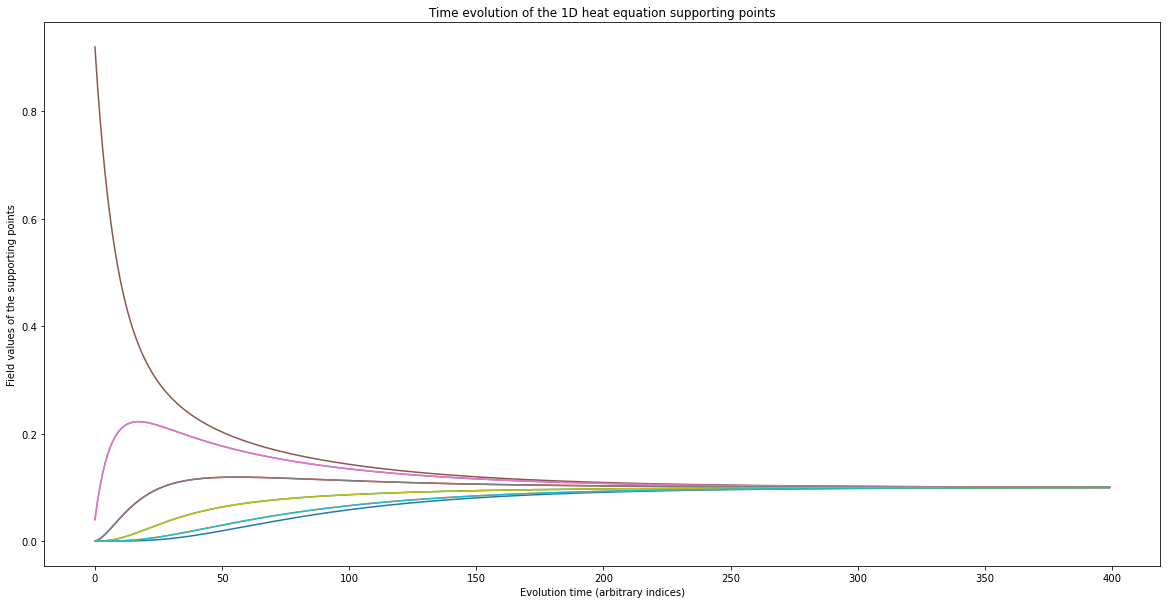

In [12]:
rcParams["figure.figsize"] = (20,10)
for i in range(N):
    plot(data[f"u{i}"])
    
xlabel("Evolution time (arbitrary indices)")
ylabel("Field values of the supporting points")
title("Time evolution of the 1D heat equation supporting points")

In the following, we reconstruct the higher-dimensional data and display it color encoded:

In [17]:
heat = array([data[f"u{i}"] for i in range(N)])

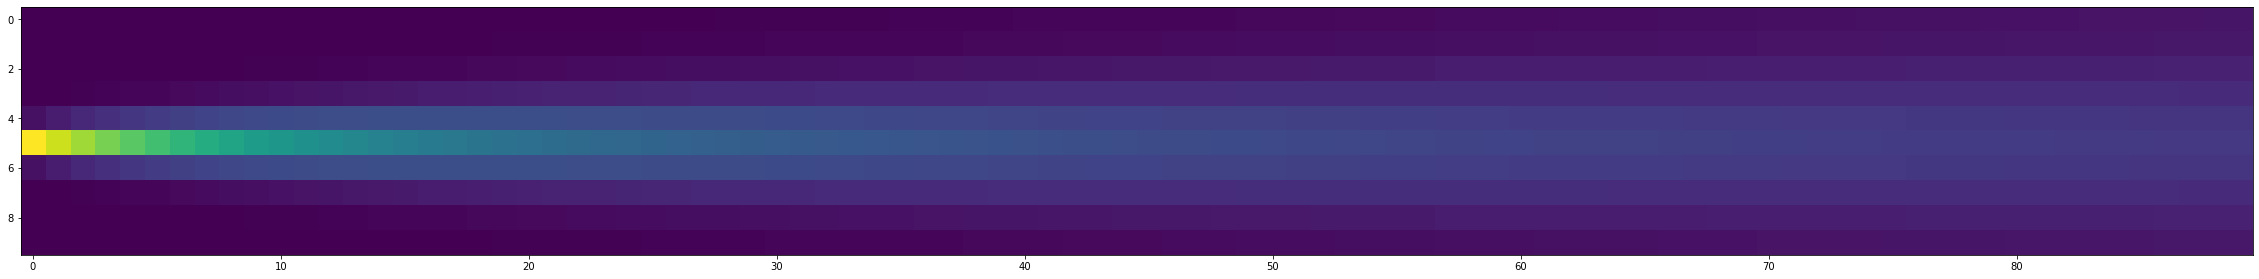

In [27]:
rcParams["figure.figsize"] = (40,20)
imshow(heat[:,0:90])

What you can see in the above plot is on the x-axis again the evolution time and on the y-axis the physical coordinate. Of course the whole image is pretty discretized. You see the initial data (one cell has value 1, all others value 0) and the equilibration of energy amongst all cells.

## 2D Heat Equation

We now solve the heat equation in two spatial and one temporal dimension, which is more similar to what is done in http://analogparadigm.com/downloads/alpaca_24.pdf

In [30]:
state = State()  # restart with a clean state

N = 10 # supporting points
NN = (N, N) # shape in two dimensions

u = array([ Symbol("u_%d_%d"%(i,j)) for i,j in ndindex(NN) ]).reshape(NN)
u

array([[u_0_0, u_0_1, u_0_2, u_0_3, u_0_4, u_0_5, u_0_6, u_0_7, u_0_8,
        u_0_9],
       [u_1_0, u_1_1, u_1_2, u_1_3, u_1_4, u_1_5, u_1_6, u_1_7, u_1_8,
        u_1_9],
       [u_2_0, u_2_1, u_2_2, u_2_3, u_2_4, u_2_5, u_2_6, u_2_7, u_2_8,
        u_2_9],
       [u_3_0, u_3_1, u_3_2, u_3_3, u_3_4, u_3_5, u_3_6, u_3_7, u_3_8,
        u_3_9],
       [u_4_0, u_4_1, u_4_2, u_4_3, u_4_4, u_4_5, u_4_6, u_4_7, u_4_8,
        u_4_9],
       [u_5_0, u_5_1, u_5_2, u_5_3, u_5_4, u_5_5, u_5_6, u_5_7, u_5_8,
        u_5_9],
       [u_6_0, u_6_1, u_6_2, u_6_3, u_6_4, u_6_5, u_6_6, u_6_7, u_6_8,
        u_6_9],
       [u_7_0, u_7_1, u_7_2, u_7_3, u_7_4, u_7_5, u_7_6, u_7_7, u_7_8,
        u_7_9],
       [u_8_0, u_8_1, u_8_2, u_8_3, u_8_4, u_8_5, u_8_6, u_8_7, u_8_8,
        u_8_9],
       [u_9_0, u_9_1, u_9_2, u_9_3, u_9_4, u_9_5, u_9_6, u_9_7, u_9_8,
        u_9_9]], dtype=object)

In [31]:
# Symbols for initial conditions:
u0 = array([ Symbol("uinitial_%d_%d"%(i,j)) for i,j in ndindex(NN) ]).reshape(NN)
u0

array([[uinitial_0_0, uinitial_0_1, uinitial_0_2, uinitial_0_3,
        uinitial_0_4, uinitial_0_5, uinitial_0_6, uinitial_0_7,
        uinitial_0_8, uinitial_0_9],
       [uinitial_1_0, uinitial_1_1, uinitial_1_2, uinitial_1_3,
        uinitial_1_4, uinitial_1_5, uinitial_1_6, uinitial_1_7,
        uinitial_1_8, uinitial_1_9],
       [uinitial_2_0, uinitial_2_1, uinitial_2_2, uinitial_2_3,
        uinitial_2_4, uinitial_2_5, uinitial_2_6, uinitial_2_7,
        uinitial_2_8, uinitial_2_9],
       [uinitial_3_0, uinitial_3_1, uinitial_3_2, uinitial_3_3,
        uinitial_3_4, uinitial_3_5, uinitial_3_6, uinitial_3_7,
        uinitial_3_8, uinitial_3_9],
       [uinitial_4_0, uinitial_4_1, uinitial_4_2, uinitial_4_3,
        uinitial_4_4, uinitial_4_5, uinitial_4_6, uinitial_4_7,
        uinitial_4_8, uinitial_4_9],
       [uinitial_5_0, uinitial_5_1, uinitial_5_2, uinitial_5_3,
        uinitial_5_4, uinitial_5_5, uinitial_5_6, uinitial_5_7,
        uinitial_5_8, uinitial_5_9],
       [ui

In [32]:
# imprint the initial conditions:

for i,j in ndindex(NN):
    state[u0[i,j]] = const(0)
    
state[ u0[5,5] ] = const(1) # our candle in the very center

# Time step
dt = Symbol("dt")
state[dt] = const(0.01)

# Let's see what we made
state

State({'dt': const(0.01),
 'uinitial_0_0': const(0),
 'uinitial_0_1': const(0),
 'uinitial_0_2': const(0),
 'uinitial_0_3': const(0),
 'uinitial_0_4': const(0),
 'uinitial_0_5': const(0),
 'uinitial_0_6': const(0),
 'uinitial_0_7': const(0),
 'uinitial_0_8': const(0),
 'uinitial_0_9': const(0),
 'uinitial_1_0': const(0),
 'uinitial_1_1': const(0),
 'uinitial_1_2': const(0),
 'uinitial_1_3': const(0),
 'uinitial_1_4': const(0),
 'uinitial_1_5': const(0),
 'uinitial_1_6': const(0),
 'uinitial_1_7': const(0),
 'uinitial_1_8': const(0),
 'uinitial_1_9': const(0),
 'uinitial_2_0': const(0),
 'uinitial_2_1': const(0),
 'uinitial_2_2': const(0),
 'uinitial_2_3': const(0),
 'uinitial_2_4': const(0),
 'uinitial_2_5': const(0),
 'uinitial_2_6': const(0),
 'uinitial_2_7': const(0),
 'uinitial_2_8': const(0),
 'uinitial_2_9': const(0),
 'uinitial_3_0': const(0),
 'uinitial_3_1': const(0),
 'uinitial_3_2': const(0),
 'uinitial_3_3': const(0),
 'uinitial_3_4': const(0),
 'uinitial_3_5': const(0),
 '

The Laplace operator is discretized as the following:

$$ \dot u_{i,j} = \alpha ( u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4 u_{i,j} ) $$

In [34]:
for i,j in ndindex(NN):
    # compute i-1 and i+1 with proper boundary conditions:
    im1 = i-1 if i>0 else N-1
    ip1 = i+1 if i!=N-1 else 0
    
    # compute j-1 and j+1 with proper boundary conditions:
    jm1 = j-1 if j>0 else N-1
    jp1 = j+1 if j!=N-1 else 0
    
    helper = Symbol(f"u_intermediate_{i}_{j}")
    state[helper] = neg(mult(4,u[i,j]))
    state[ u[i,j] ] = int(mult(alpha,sum(
        u[im1,j], u[ip1,j],
        u[i,jm1], u[i,jp1],
        helper)), dt, u0[i,j])
    
len(state)

301

The state is already enormous. Realizing this circuit requires more then 300 wires or computing elements, respectively:

In [35]:
state

State({'dt': const(0.01),
 'u_0_0': int(mult(const(4), sum(u_9_0, u_1_0, u_0_9, u_0_1, u_intermediate_0_0)), dt, uinitial_0_0),
 'u_0_1': int(mult(const(4), sum(u_9_1, u_1_1, u_0_0, u_0_2, u_intermediate_0_1)), dt, uinitial_0_1),
 'u_0_2': int(mult(const(4), sum(u_9_2, u_1_2, u_0_1, u_0_3, u_intermediate_0_2)), dt, uinitial_0_2),
 'u_0_3': int(mult(const(4), sum(u_9_3, u_1_3, u_0_2, u_0_4, u_intermediate_0_3)), dt, uinitial_0_3),
 'u_0_4': int(mult(const(4), sum(u_9_4, u_1_4, u_0_3, u_0_5, u_intermediate_0_4)), dt, uinitial_0_4),
 'u_0_5': int(mult(const(4), sum(u_9_5, u_1_5, u_0_4, u_0_6, u_intermediate_0_5)), dt, uinitial_0_5),
 'u_0_6': int(mult(const(4), sum(u_9_6, u_1_6, u_0_5, u_0_7, u_intermediate_0_6)), dt, uinitial_0_6),
 'u_0_7': int(mult(const(4), sum(u_9_7, u_1_7, u_0_6, u_0_8, u_intermediate_0_7)), dt, uinitial_0_7),
 'u_0_8': int(mult(const(4), sum(u_9_8, u_1_8, u_0_7, u_0_9, u_intermediate_0_8)), dt, uinitial_0_8),
 'u_0_9': int(mult(const(4), sum(u_9_9, u_1_9, u_0_8, u_

In [36]:
c_code = state.export(to="C")
compile(c_code, "heateq2d.cpp")

In [37]:
data = run(arguments={'max_iterations':400})

Running: ./a.out --max_iterations=400


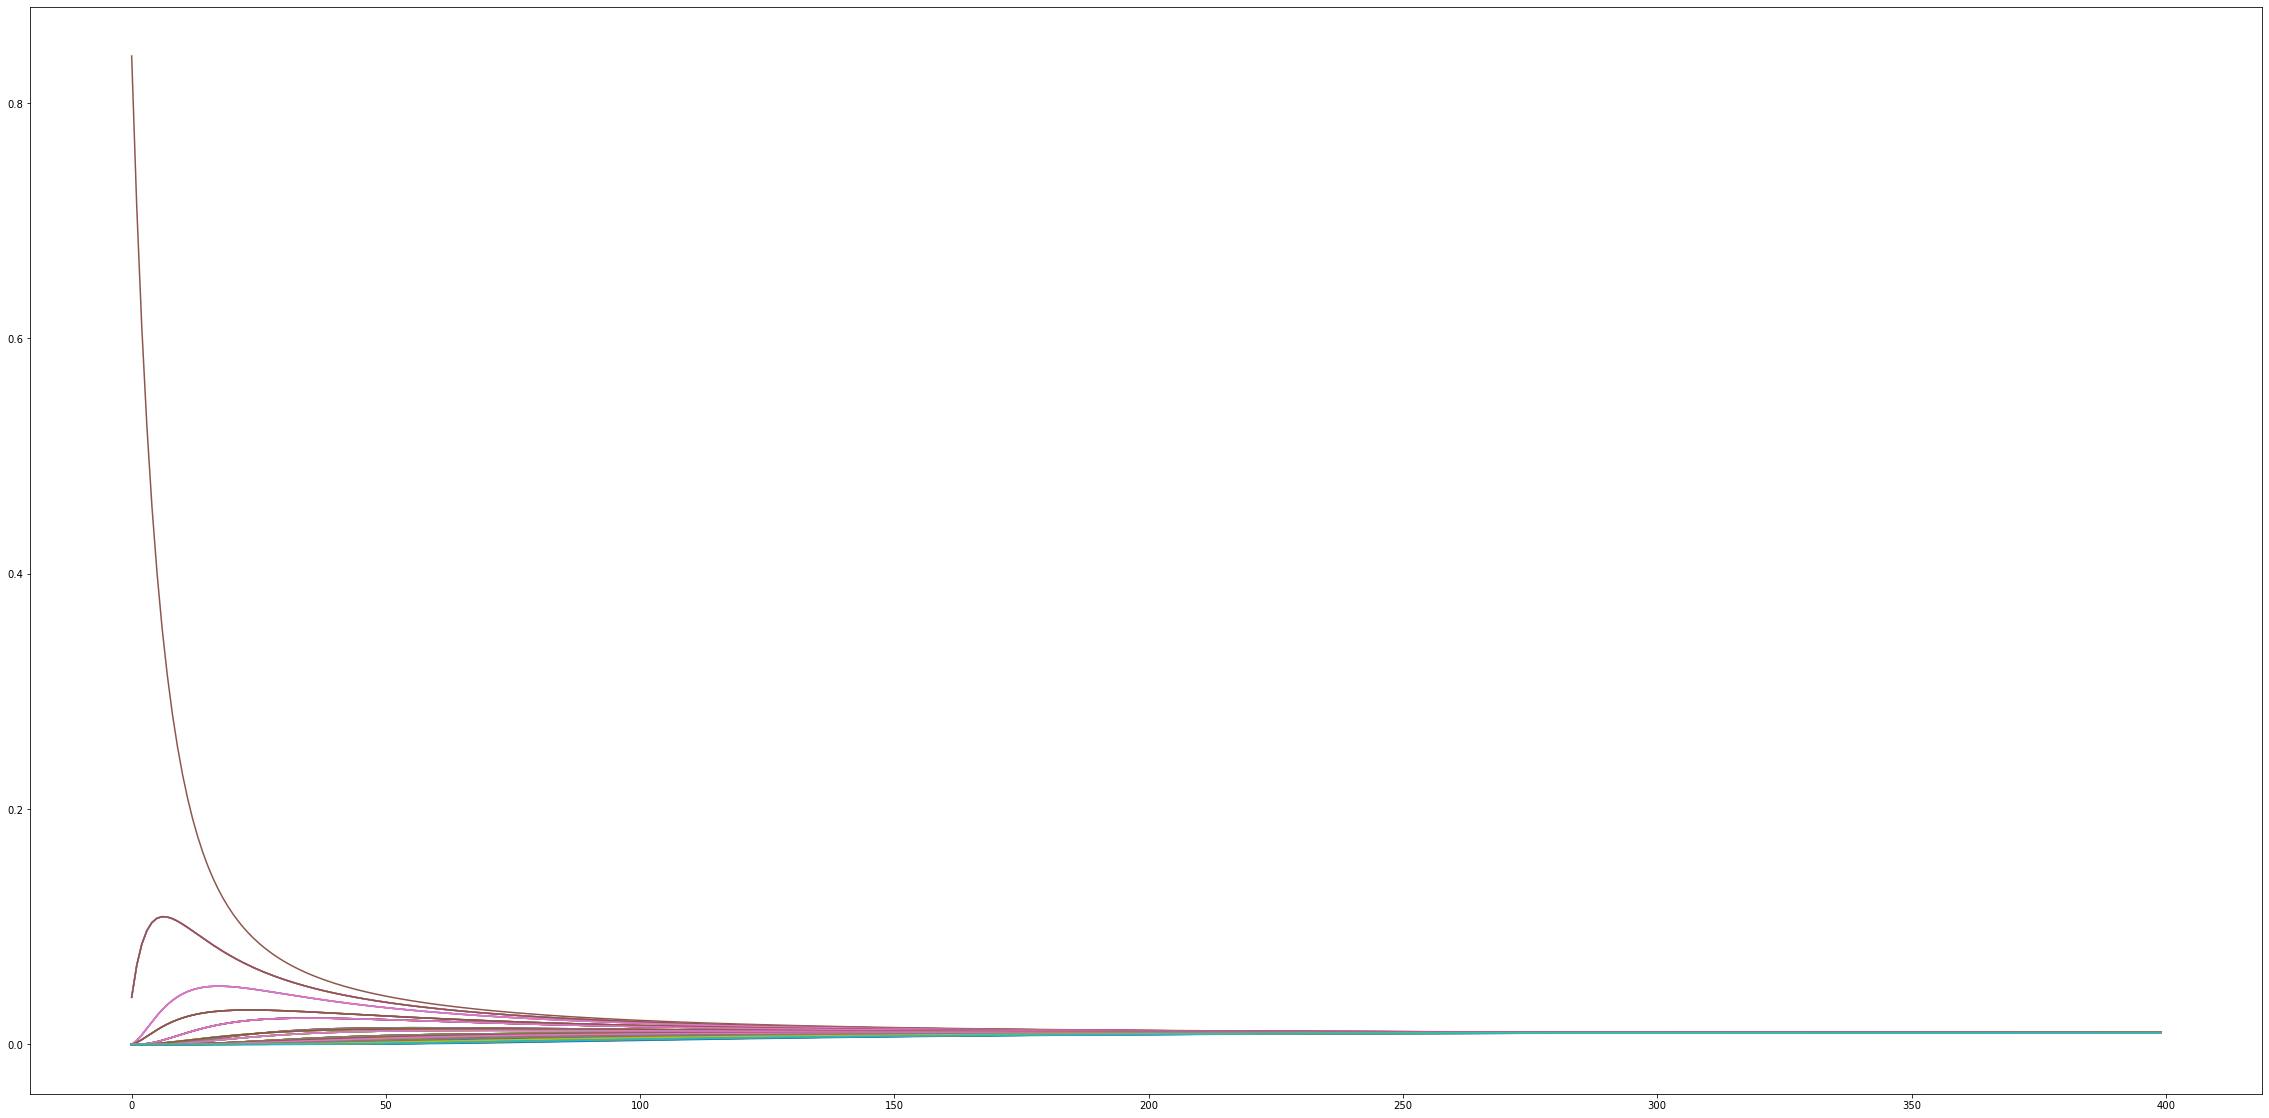

In [38]:
for i,j in ndindex(NN):
    plot(data[f"u_{i}_{j}"])

In [39]:
heat = array([data[f"u_{i}_{j}"] for i,j in ndindex(NN)]).reshape((N,N,len(data)))
heat.shape

(10, 10, 400)

The physical recovery of the digital data is not so easy to inspect, since the two spatial dimensions would require to make a movie in order to display the time evolution. What we do instead here is to show the first snapshot and the last one.

In the following two figures, the *x* and *y* axis correspond to their physical coordinates. These are *still images* for $t=0$ and $t=t_\text{final}$.

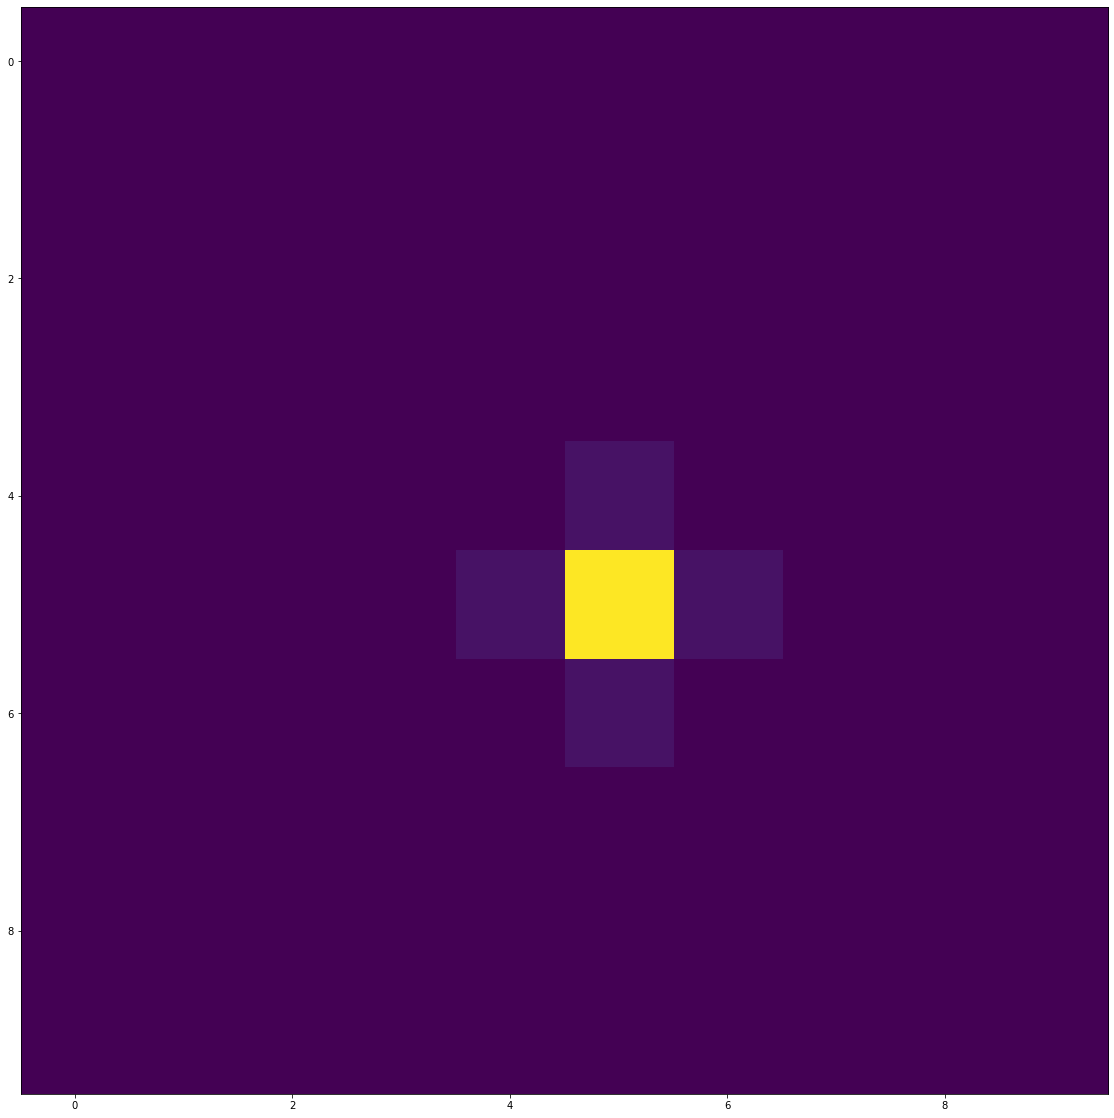

In [22]:
rcParams["figure.figsize"] = (40,20)
imshow(heat[:,:,0])

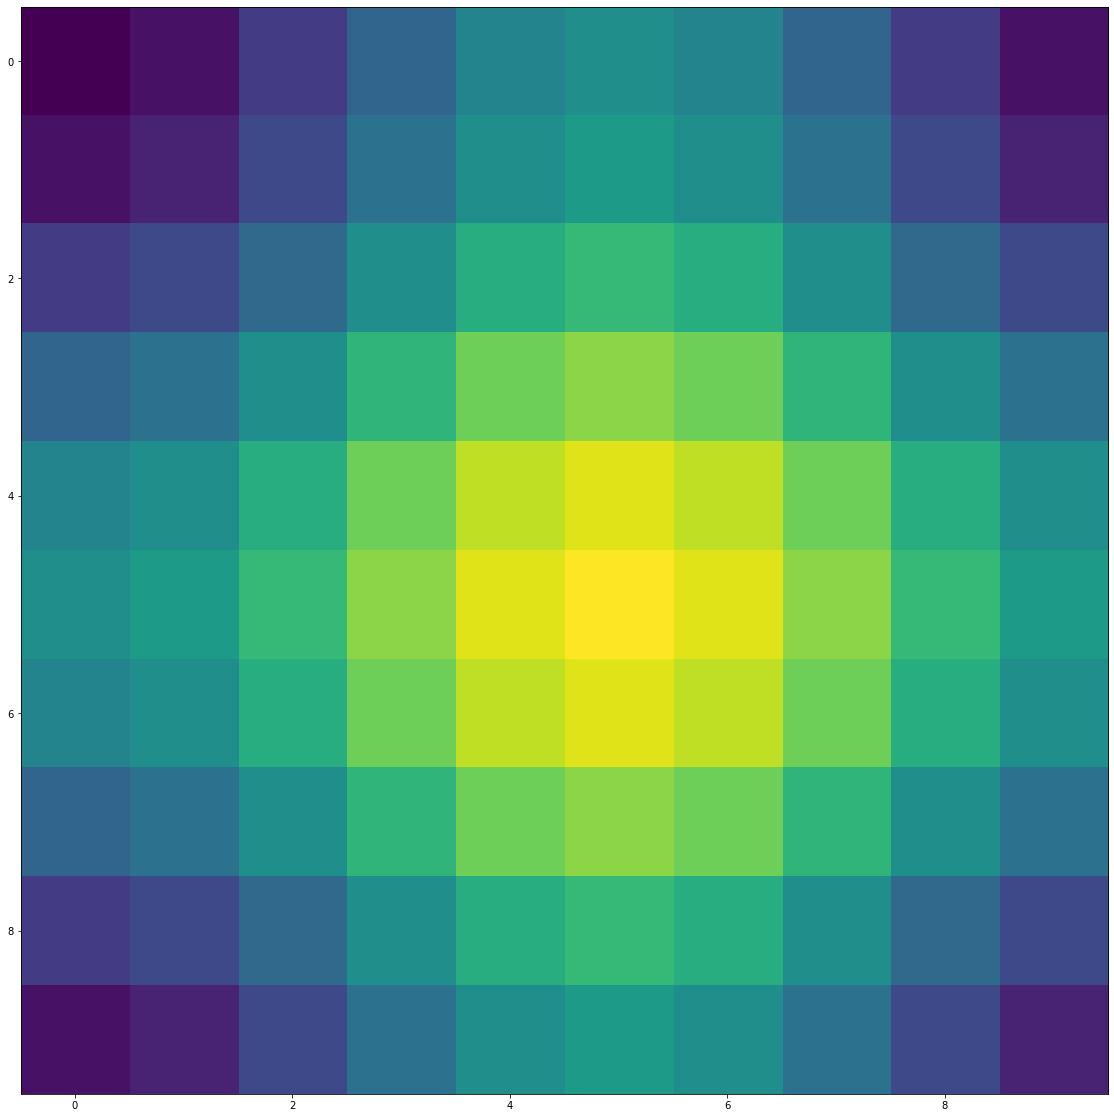

In [23]:
imshow(heat[:,:,-1])

In order to provide a final discussion, what is visible here is the dissipation of heat from a single maximum to the whole simulation domain.

With this, we end the demonstration notebook about the heat equation in DDA.

### About this notebook

This notebook was written during a two hour phone call as an interactive demonstration how to do high-level programming with DDA. 